### Data loading and preprocessing

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
import optuna
from sklearn.metrics import confusion_matrix, f1_score,classification_report
import matplotlib.pyplot as plt
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler

In [2]:
#Load data
df = pd.read_json(r'C:\Code\ML_Project\Data\preprocessed_movieDB.json')
df=df[df['revenue']<100*1e+6]

In [3]:
scaler = MinMaxScaler()
df['budget'] = scaler.fit_transform(df['budget'].values.reshape(-1, 1))

In [4]:
# Creating binning
bin_size =20
df['revenue_bin'] = np.floor(df['revenue'] / (bin_size*1e+6 )).astype(int)

In [5]:
#Create feature and class target
X = df.drop(['title', 'revenue', 'revenue_bin'], axis=1)
y = df['revenue_bin']

In [6]:
# Standard scale
scaler = StandardScaler()
X= scaler.fit_transform(X)

In [7]:
#Train, validation, test set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### Creating model

In [8]:
#Function to create model
def create_model(trial):
    input_dim = X_train.shape[1]
    number_labels = 5

    num_layers = trial.suggest_int('num_layers', 1, 5)
    
    model = Sequential()
    model.add(Input(shape=(input_dim,)))

    previous_layer_size = trial.suggest_int('layer_size_0', 32, 512)
    model.add(Dense(previous_layer_size, activation='relu'))

    for i in range(1, num_layers):
        layer_size = trial.suggest_int(f'layer_size_{i}', 32, previous_layer_size)
        dropout_rate = trial.suggest_float(f'dropout_rate_{i}', 0.0, 0.5)
        model.add(Dense(layer_size, activation='relu'))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
        previous_layer_size = layer_size

    model.add(Dense(number_labels, activation='softmax'))

    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

### Objective function 

In [9]:
#Objective function
def objective(trial):
    model = create_model(trial)
    
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_val, y_val),
        verbose=0)

    test_accuracy = model.evaluate(X_test, y_test)[1]
    return test_accuracy

### Optuna Study

In [10]:
# Create a study with TPE sampler and median pruner
study = optuna.create_study(sampler=TPESampler(), pruner=MedianPruner(), direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-05-31 05:36:10,386] A new study created in memory with name: no-name-f43de5f1-ac02-4a48-b26d-d107c94a6fda


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6402 - loss: 3.5081 


[I 2024-05-31 05:36:55,762] Trial 0 finished with value: 0.6315789222717285 and parameters: {'num_layers': 4, 'layer_size_0': 462, 'layer_size_1': 316, 'dropout_rate_1': 0.17767777403405122, 'layer_size_2': 177, 'dropout_rate_2': 0.0420321852037463, 'layer_size_3': 77, 'dropout_rate_3': 0.3151704816592405}. Best is trial 0 with value: 0.6315789222717285.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - accuracy: 0.6452 - loss: 1.3446


[I 2024-05-31 05:37:19,617] Trial 1 finished with value: 0.6276803016662598 and parameters: {'num_layers': 1, 'layer_size_0': 469}. Best is trial 0 with value: 0.6315789222717285.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6539 - loss: 3.2404 


[I 2024-05-31 05:37:55,904] Trial 2 finished with value: 0.6374269127845764 and parameters: {'num_layers': 5, 'layer_size_0': 207, 'layer_size_1': 180, 'dropout_rate_1': 0.09931079075271376, 'layer_size_2': 146, 'dropout_rate_2': 0.4203919046631115, 'layer_size_3': 86, 'dropout_rate_3': 0.37260267589928897, 'layer_size_4': 41, 'dropout_rate_4': 0.16989130092037585}. Best is trial 2 with value: 0.6374269127845764.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6476 - loss: 3.5353 


[I 2024-05-31 05:38:39,284] Trial 3 finished with value: 0.6315789222717285 and parameters: {'num_layers': 4, 'layer_size_0': 466, 'layer_size_1': 248, 'dropout_rate_1': 0.012878460445856, 'layer_size_2': 136, 'dropout_rate_2': 0.40636677131440974, 'layer_size_3': 83, 'dropout_rate_3': 0.003524454176765335}. Best is trial 2 with value: 0.6374269127845764.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6295 - loss: 1.2634 


[I 2024-05-31 05:39:02,635] Trial 4 finished with value: 0.6335282921791077 and parameters: {'num_layers': 1, 'layer_size_0': 291}. Best is trial 2 with value: 0.6374269127845764.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6435 - loss: 1.2989 


[I 2024-05-31 05:39:25,723] Trial 5 finished with value: 0.6413255333900452 and parameters: {'num_layers': 1, 'layer_size_0': 406}. Best is trial 5 with value: 0.6413255333900452.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6570 - loss: 3.3225 


[I 2024-05-31 05:40:13,533] Trial 6 finished with value: 0.6393762230873108 and parameters: {'num_layers': 3, 'layer_size_0': 495, 'layer_size_1': 403, 'dropout_rate_1': 0.3242055768879628, 'layer_size_2': 81, 'dropout_rate_2': 0.2329260118156815}. Best is trial 5 with value: 0.6413255333900452.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6561 - loss: 1.2197 


[I 2024-05-31 05:40:35,639] Trial 7 finished with value: 0.6413255333900452 and parameters: {'num_layers': 1, 'layer_size_0': 266}. Best is trial 5 with value: 0.6413255333900452.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6267 - loss: 3.1111 


[I 2024-05-31 05:41:13,248] Trial 8 finished with value: 0.623781681060791 and parameters: {'num_layers': 5, 'layer_size_0': 448, 'layer_size_1': 104, 'dropout_rate_1': 0.061137236462999345, 'layer_size_2': 74, 'dropout_rate_2': 0.2799085976916441, 'layer_size_3': 60, 'dropout_rate_3': 0.48782164675724765, 'layer_size_4': 34, 'dropout_rate_4': 0.45405935083451276}. Best is trial 5 with value: 0.6413255333900452.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6219 - loss: 1.4865 


[I 2024-05-31 05:41:36,980] Trial 9 finished with value: 0.6140350699424744 and parameters: {'num_layers': 1, 'layer_size_0': 465}. Best is trial 5 with value: 0.6413255333900452.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7063 - loss: 0.9059 


[I 2024-05-31 05:42:00,984] Trial 10 finished with value: 0.6783625483512878 and parameters: {'num_layers': 2, 'layer_size_0': 52, 'layer_size_1': 32, 'dropout_rate_1': 0.49358698179650884}. Best is trial 10 with value: 0.6783625483512878.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6759 - loss: 0.8935 


[I 2024-05-31 05:42:25,812] Trial 11 finished with value: 0.6588693857192993 and parameters: {'num_layers': 2, 'layer_size_0': 42, 'layer_size_1': 32, 'dropout_rate_1': 0.4782417379183037}. Best is trial 10 with value: 0.6783625483512878.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6687 - loss: 0.8529 


[I 2024-05-31 05:42:50,619] Trial 12 finished with value: 0.6705653071403503 and parameters: {'num_layers': 2, 'layer_size_0': 35, 'layer_size_1': 32, 'dropout_rate_1': 0.49821481040721266}. Best is trial 10 with value: 0.6783625483512878.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6684 - loss: 0.8808 


[I 2024-05-31 05:43:16,930] Trial 13 finished with value: 0.6569200754165649 and parameters: {'num_layers': 2, 'layer_size_0': 34, 'layer_size_1': 32, 'dropout_rate_1': 0.4676986619714716}. Best is trial 10 with value: 0.6783625483512878.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6602 - loss: 1.3984 


[I 2024-05-31 05:43:43,969] Trial 14 finished with value: 0.6530214548110962 and parameters: {'num_layers': 2, 'layer_size_0': 126, 'layer_size_1': 50, 'dropout_rate_1': 0.353380813996308}. Best is trial 10 with value: 0.6783625483512878.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6628 - loss: 1.5202 


[I 2024-05-31 05:44:13,655] Trial 15 finished with value: 0.6569200754165649 and parameters: {'num_layers': 3, 'layer_size_0': 107, 'layer_size_1': 50, 'dropout_rate_1': 0.38579909416557634, 'layer_size_2': 35, 'dropout_rate_2': 0.008674068177781158}. Best is trial 10 with value: 0.6783625483512878.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6514 - loss: 1.1860 


[I 2024-05-31 05:44:39,672] Trial 16 finished with value: 0.6413255333900452 and parameters: {'num_layers': 2, 'layer_size_0': 118, 'layer_size_1': 55, 'dropout_rate_1': 0.4784036275662137}. Best is trial 10 with value: 0.6783625483512878.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6657 - loss: 2.3223 


[I 2024-05-31 05:45:09,286] Trial 17 finished with value: 0.6471734642982483 and parameters: {'num_layers': 3, 'layer_size_0': 193, 'layer_size_1': 87, 'dropout_rate_1': 0.2526718471962627, 'layer_size_2': 36, 'dropout_rate_2': 0.1685775810362473}. Best is trial 10 with value: 0.6783625483512878.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6595 - loss: 1.0461 


[I 2024-05-31 05:45:34,919] Trial 18 finished with value: 0.6530214548110962 and parameters: {'num_layers': 2, 'layer_size_0': 79, 'layer_size_1': 41, 'dropout_rate_1': 0.39753371767131096}. Best is trial 10 with value: 0.6783625483512878.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - accuracy: 0.6611 - loss: 1.6829


[I 2024-05-31 05:45:59,950] Trial 19 finished with value: 0.6471734642982483 and parameters: {'num_layers': 4, 'layer_size_0': 176, 'layer_size_1': 72, 'dropout_rate_1': 0.2792937250458755, 'layer_size_2': 48, 'dropout_rate_2': 0.48270661748916815, 'layer_size_3': 32, 'dropout_rate_3': 0.0599799340906953}. Best is trial 10 with value: 0.6783625483512878.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - accuracy: 0.6442 - loss: 2.6612


[I 2024-05-31 05:46:21,991] Trial 20 finished with value: 0.6393762230873108 and parameters: {'num_layers': 3, 'layer_size_0': 333, 'layer_size_1': 133, 'dropout_rate_1': 0.42273421481953, 'layer_size_2': 62, 'dropout_rate_2': 0.12170100748602908}. Best is trial 10 with value: 0.6783625483512878.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - accuracy: 0.6624 - loss: 0.8432


[I 2024-05-31 05:46:38,931] Trial 21 finished with value: 0.6588693857192993 and parameters: {'num_layers': 2, 'layer_size_0': 33, 'layer_size_1': 32, 'dropout_rate_1': 0.4968607323521313}. Best is trial 10 with value: 0.6783625483512878.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - accuracy: 0.6404 - loss: 1.0714


[I 2024-05-31 05:46:56,061] Trial 22 finished with value: 0.6374269127845764 and parameters: {'num_layers': 2, 'layer_size_0': 72, 'layer_size_1': 38, 'dropout_rate_1': 0.4436360307030267}. Best is trial 10 with value: 0.6783625483512878.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - accuracy: 0.6478 - loss: 1.5185


[I 2024-05-31 05:47:13,026] Trial 23 finished with value: 0.635477602481842 and parameters: {'num_layers': 2, 'layer_size_0': 151, 'layer_size_1': 71, 'dropout_rate_1': 0.49930078225466146}. Best is trial 10 with value: 0.6783625483512878.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - accuracy: 0.6724 - loss: 1.1361


[I 2024-05-31 05:47:30,974] Trial 24 finished with value: 0.668615996837616 and parameters: {'num_layers': 3, 'layer_size_0': 66, 'layer_size_1': 37, 'dropout_rate_1': 0.4273508382334933, 'layer_size_2': 32, 'dropout_rate_2': 0.323104781063729}. Best is trial 10 with value: 0.6783625483512878.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - accuracy: 0.6515 - loss: 1.1835


[I 2024-05-31 05:47:48,650] Trial 25 finished with value: 0.6452241539955139 and parameters: {'num_layers': 3, 'layer_size_0': 86, 'layer_size_1': 40, 'dropout_rate_1': 0.41877132718804605, 'layer_size_2': 32, 'dropout_rate_2': 0.32944159871611695}. Best is trial 10 with value: 0.6783625483512878.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - accuracy: 0.6532 - loss: 1.7798


[I 2024-05-31 05:48:06,684] Trial 26 finished with value: 0.6432748436927795 and parameters: {'num_layers': 3, 'layer_size_0': 158, 'layer_size_1': 62, 'dropout_rate_1': 0.3400740380226269, 'layer_size_2': 41, 'dropout_rate_2': 0.3362539698354603}. Best is trial 10 with value: 0.6783625483512878.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - accuracy: 0.6638 - loss: 2.8801


[I 2024-05-31 05:48:27,879] Trial 27 finished with value: 0.635477602481842 and parameters: {'num_layers': 4, 'layer_size_0': 224, 'layer_size_1': 94, 'dropout_rate_1': 0.19165790265145205, 'layer_size_2': 54, 'dropout_rate_2': 0.20804096230904545, 'layer_size_3': 32, 'dropout_rate_3': 0.18999022371017196}. Best is trial 10 with value: 0.6783625483512878.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - accuracy: 0.6781 - loss: 1.1479


[I 2024-05-31 05:48:45,872] Trial 28 finished with value: 0.6627680063247681 and parameters: {'num_layers': 3, 'layer_size_0': 69, 'layer_size_1': 36, 'dropout_rate_1': 0.44242848407439744, 'layer_size_2': 32, 'dropout_rate_2': 0.10148371876014417}. Best is trial 10 with value: 0.6783625483512878.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - accuracy: 0.6570 - loss: 1.7592


[I 2024-05-31 05:49:03,595] Trial 29 finished with value: 0.6432748436927795 and parameters: {'num_layers': 3, 'layer_size_0': 134, 'layer_size_1': 49, 'dropout_rate_1': 0.37352813740823304, 'layer_size_2': 38, 'dropout_rate_2': 0.32059898631655176}. Best is trial 10 with value: 0.6783625483512878.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - accuracy: 0.6503 - loss: 2.2895


[I 2024-05-31 05:49:26,950] Trial 30 finished with value: 0.6452241539955139 and parameters: {'num_layers': 4, 'layer_size_0': 369, 'layer_size_1': 144, 'dropout_rate_1': 0.3170061422475693, 'layer_size_2': 99, 'dropout_rate_2': 0.3958100134548298, 'layer_size_3': 54, 'dropout_rate_3': 0.16743243372124833}. Best is trial 10 with value: 0.6783625483512878.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - accuracy: 0.6863 - loss: 1.1074


[I 2024-05-31 05:49:43,999] Trial 31 finished with value: 0.6842105388641357 and parameters: {'num_layers': 3, 'layer_size_0': 58, 'layer_size_1': 35, 'dropout_rate_1': 0.4306192392498163, 'layer_size_2': 32, 'dropout_rate_2': 0.09900474187109354}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - accuracy: 0.6451 - loss: 1.2408


[I 2024-05-31 05:50:00,890] Trial 32 finished with value: 0.6452241539955139 and parameters: {'num_layers': 2, 'layer_size_0': 96, 'layer_size_1': 43, 'dropout_rate_1': 0.4486112641937058}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - accuracy: 0.6546 - loss: 1.1906


[I 2024-05-31 05:50:18,089] Trial 33 finished with value: 0.6608186960220337 and parameters: {'num_layers': 3, 'layer_size_0': 63, 'layer_size_1': 36, 'dropout_rate_1': 0.4128297603085439, 'layer_size_2': 33, 'dropout_rate_2': 0.16554856846121274}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - accuracy: 0.6778 - loss: 0.9080


[I 2024-05-31 05:50:36,708] Trial 34 finished with value: 0.6705653071403503 and parameters: {'num_layers': 4, 'layer_size_0': 51, 'layer_size_1': 34, 'dropout_rate_1': 0.46192159322456094, 'layer_size_2': 32, 'dropout_rate_2': 0.0874504103499728, 'layer_size_3': 32, 'dropout_rate_3': 0.48818977642192246}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - accuracy: 0.6497 - loss: 1.6242


[I 2024-05-31 05:50:58,469] Trial 35 finished with value: 0.6393762230873108 and parameters: {'num_layers': 5, 'layer_size_0': 244, 'layer_size_1': 68, 'dropout_rate_1': 0.182559710888198, 'layer_size_2': 43, 'dropout_rate_2': 0.07891729761696464, 'layer_size_3': 36, 'dropout_rate_3': 0.48830469563693407, 'layer_size_4': 32, 'dropout_rate_4': 0.05682339399270819}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - accuracy: 0.6771 - loss: 1.0556


[I 2024-05-31 05:51:17,233] Trial 36 finished with value: 0.6705653071403503 and parameters: {'num_layers': 4, 'layer_size_0': 49, 'layer_size_1': 34, 'dropout_rate_1': 0.46370696182871973, 'layer_size_2': 32, 'dropout_rate_2': 0.15139272180901034, 'layer_size_3': 32, 'dropout_rate_3': 0.38659606600957536}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - accuracy: 0.6359 - loss: 1.9013


[I 2024-05-31 05:51:37,565] Trial 37 finished with value: 0.6335282921791077 and parameters: {'num_layers': 5, 'layer_size_0': 102, 'layer_size_1': 45, 'dropout_rate_1': 0.1372675820337374, 'layer_size_2': 34, 'dropout_rate_2': 0.04668318226598667, 'layer_size_3': 33, 'dropout_rate_3': 0.2983360842227915, 'layer_size_4': 32, 'dropout_rate_4': 0.45731718407021066}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - accuracy: 0.6747 - loss: 1.2461


[I 2024-05-31 05:51:59,813] Trial 38 finished with value: 0.6549707651138306 and parameters: {'num_layers': 4, 'layer_size_0': 133, 'layer_size_1': 56, 'dropout_rate_1': 0.4996889176155012, 'layer_size_2': 37, 'dropout_rate_2': 0.2043017857060053, 'layer_size_3': 34, 'dropout_rate_3': 0.41396067369098355}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - accuracy: 0.6343 - loss: 1.0841


[I 2024-05-31 05:52:13,899] Trial 39 finished with value: 0.6393762230873108 and parameters: {'num_layers': 1, 'layer_size_0': 153}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - accuracy: 0.6395 - loss: 1.3440


[I 2024-05-31 05:52:28,003] Trial 40 finished with value: 0.6413255333900452 and parameters: {'num_layers': 1, 'layer_size_0': 314}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - accuracy: 0.6676 - loss: 0.8922


[I 2024-05-31 05:52:46,621] Trial 41 finished with value: 0.6569200754165649 and parameters: {'num_layers': 4, 'layer_size_0': 38, 'layer_size_1': 33, 'dropout_rate_1': 0.45660975203235016, 'layer_size_2': 32, 'dropout_rate_2': 0.13283911979472252, 'layer_size_3': 32, 'dropout_rate_3': 0.4069926248093221}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - accuracy: 0.6678 - loss: 1.1255


[I 2024-05-31 05:53:04,765] Trial 42 finished with value: 0.668615996837616 and parameters: {'num_layers': 4, 'layer_size_0': 58, 'layer_size_1': 34, 'dropout_rate_1': 0.4627418572970838, 'layer_size_2': 32, 'dropout_rate_2': 0.15677045226445038, 'layer_size_3': 32, 'dropout_rate_3': 0.49728098416595934}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - accuracy: 0.6507 - loss: 1.1513


[I 2024-05-31 05:53:24,834] Trial 43 finished with value: 0.6510721445083618 and parameters: {'num_layers': 5, 'layer_size_0': 48, 'layer_size_1': 34, 'dropout_rate_1': 0.386000841327336, 'layer_size_2': 32, 'dropout_rate_2': 0.08153481945012969, 'layer_size_3': 32, 'dropout_rate_3': 0.3493713889972359, 'layer_size_4': 32, 'dropout_rate_4': 0.2804632767306523}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - accuracy: 0.6539 - loss: 1.1757


[I 2024-05-31 05:53:43,630] Trial 44 finished with value: 0.6510721445083618 and parameters: {'num_layers': 4, 'layer_size_0': 84, 'layer_size_1': 39, 'dropout_rate_1': 0.4734664545684889, 'layer_size_2': 33, 'dropout_rate_2': 0.00660960694968446, 'layer_size_3': 32, 'dropout_rate_3': 0.42829389946345175}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - accuracy: 0.6740 - loss: 1.1734


[I 2024-05-31 05:54:02,174] Trial 45 finished with value: 0.6705653071403503 and parameters: {'num_layers': 4, 'layer_size_0': 106, 'layer_size_1': 45, 'dropout_rate_1': 0.4363157143602484, 'layer_size_2': 34, 'dropout_rate_2': 0.04910426104079041, 'layer_size_3': 33, 'dropout_rate_3': 0.24678307068134964}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - accuracy: 0.6653 - loss: 0.9717


[I 2024-05-31 05:54:17,168] Trial 46 finished with value: 0.6627680063247681 and parameters: {'num_layers': 2, 'layer_size_0': 32, 'layer_size_1': 32, 'dropout_rate_1': 0.00644180076552936}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - accuracy: 0.5773 - loss: 0.9821


[I 2024-05-31 05:54:36,917] Trial 47 finished with value: 0.5789473652839661 and parameters: {'num_layers': 5, 'layer_size_0': 56, 'layer_size_1': 35, 'dropout_rate_1': 0.47320327215257796, 'layer_size_2': 33, 'dropout_rate_2': 0.1333352081274608, 'layer_size_3': 32, 'dropout_rate_3': 0.4418625825186214, 'layer_size_4': 32, 'dropout_rate_4': 0.012244007168417115}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - accuracy: 0.6541 - loss: 0.9473


[I 2024-05-31 05:54:50,995] Trial 48 finished with value: 0.6510721445083618 and parameters: {'num_layers': 1, 'layer_size_0': 88}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - accuracy: 0.6339 - loss: 1.0673


[I 2024-05-31 05:55:08,385] Trial 49 finished with value: 0.6374269127845764 and parameters: {'num_layers': 3, 'layer_size_0': 58, 'layer_size_1': 34, 'dropout_rate_1': 0.35569700335667687, 'layer_size_2': 32, 'dropout_rate_2': 0.08492890900790313}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - accuracy: 0.6595 - loss: 2.6852


[I 2024-05-31 05:55:32,629] Trial 50 finished with value: 0.6393762230873108 and parameters: {'num_layers': 2, 'layer_size_0': 433, 'layer_size_1': 258, 'dropout_rate_1': 0.40585213569490886}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - accuracy: 0.6442 - loss: 1.2421


[I 2024-05-31 05:55:50,722] Trial 51 finished with value: 0.6393762230873108 and parameters: {'num_layers': 4, 'layer_size_0': 111, 'layer_size_1': 46, 'dropout_rate_1': 0.44437479237179084, 'layer_size_2': 34, 'dropout_rate_2': 0.046254907175407964, 'layer_size_3': 33, 'dropout_rate_3': 0.23777854781754523}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - accuracy: 0.6811 - loss: 1.3904


[I 2024-05-31 05:56:09,417] Trial 52 finished with value: 0.668615996837616 and parameters: {'num_layers': 4, 'layer_size_0': 100, 'layer_size_1': 42, 'dropout_rate_1': 0.4858442519018826, 'layer_size_2': 34, 'dropout_rate_2': 0.046630325729365485, 'layer_size_3': 33, 'dropout_rate_3': 0.2677993298283891}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - accuracy: 0.6387 - loss: 2.0374


[I 2024-05-31 05:56:32,098] Trial 53 finished with value: 0.6510721445083618 and parameters: {'num_layers': 4, 'layer_size_0': 510, 'layer_size_1': 111, 'dropout_rate_1': 0.4338007595986354, 'layer_size_2': 50, 'dropout_rate_2': 0.10494416837761569, 'layer_size_3': 37, 'dropout_rate_3': 0.14173868710188453}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - accuracy: 0.6229 - loss: 1.3750


[I 2024-05-31 05:56:50,884] Trial 54 finished with value: 0.6159843802452087 and parameters: {'num_layers': 5, 'layer_size_0': 51, 'layer_size_1': 33, 'dropout_rate_1': 0.049176593508664046, 'layer_size_2': 32, 'dropout_rate_2': 0.05835462859729834, 'layer_size_3': 32, 'dropout_rate_3': 0.23672206736071089, 'layer_size_4': 32, 'dropout_rate_4': 0.26280690330610823}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - accuracy: 0.6529 - loss: 1.3651


[I 2024-05-31 05:57:09,270] Trial 55 finished with value: 0.6530214548110962 and parameters: {'num_layers': 4, 'layer_size_0': 124, 'layer_size_1': 48, 'dropout_rate_1': 0.4639111753716832, 'layer_size_2': 35, 'dropout_rate_2': 0.18982745270478762, 'layer_size_3': 33, 'dropout_rate_3': 0.3529451178721792}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - accuracy: 0.6633 - loss: 1.3360


[I 2024-05-31 05:57:28,642] Trial 56 finished with value: 0.6608186960220337 and parameters: {'num_layers': 4, 'layer_size_0': 76, 'layer_size_1': 38, 'dropout_rate_1': 0.3705579064986842, 'layer_size_2': 33, 'dropout_rate_2': 0.021944385798014138, 'layer_size_3': 32, 'dropout_rate_3': 0.4503213738133963}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - accuracy: 0.6543 - loss: 1.9548


[I 2024-05-31 05:57:46,136] Trial 57 finished with value: 0.635477602481842 and parameters: {'num_layers': 3, 'layer_size_0': 183, 'layer_size_1': 57, 'dropout_rate_1': 0.31246141867534405, 'layer_size_2': 39, 'dropout_rate_2': 0.23022709150870166}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - accuracy: 0.6878 - loss: 0.8622


[I 2024-05-31 05:58:00,643] Trial 58 finished with value: 0.6705653071403503 and parameters: {'num_layers': 2, 'layer_size_0': 36, 'layer_size_1': 33, 'dropout_rate_1': 0.4780136483003228}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - accuracy: 0.6448 - loss: 1.1790


[I 2024-05-31 05:58:18,152] Trial 59 finished with value: 0.6491228342056274 and parameters: {'num_layers': 3, 'layer_size_0': 82, 'layer_size_1': 40, 'dropout_rate_1': 0.4052905747547413, 'layer_size_2': 33, 'dropout_rate_2': 0.2661690242340447}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - accuracy: 0.6276 - loss: 1.4519


[I 2024-05-31 05:58:37,835] Trial 60 finished with value: 0.6374269127845764 and parameters: {'num_layers': 4, 'layer_size_0': 112, 'layer_size_1': 42, 'dropout_rate_1': 0.42778360259133236, 'layer_size_2': 35, 'dropout_rate_2': 0.1454349850341901, 'layer_size_3': 34, 'dropout_rate_3': 0.377009935833707}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - accuracy: 0.6797 - loss: 0.9189


[I 2024-05-31 05:58:53,802] Trial 61 finished with value: 0.6549707651138306 and parameters: {'num_layers': 2, 'layer_size_0': 47, 'layer_size_1': 33, 'dropout_rate_1': 0.48515354203121047}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - accuracy: 0.7002 - loss: 0.8331


[I 2024-05-31 05:59:08,991] Trial 62 finished with value: 0.6783625483512878 and parameters: {'num_layers': 2, 'layer_size_0': 33, 'layer_size_1': 32, 'dropout_rate_1': 0.4668314706898994}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - accuracy: 0.6602 - loss: 1.1018


[I 2024-05-31 05:59:24,367] Trial 63 finished with value: 0.6413255333900452 and parameters: {'num_layers': 2, 'layer_size_0': 68, 'layer_size_1': 35, 'dropout_rate_1': 0.4538106504613938}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - accuracy: 0.6847 - loss: 0.9236


[I 2024-05-31 05:59:39,546] Trial 64 finished with value: 0.6725146174430847 and parameters: {'num_layers': 2, 'layer_size_0': 49, 'layer_size_1': 32, 'dropout_rate_1': 0.4963135915719425}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - accuracy: 0.6773 - loss: 0.8948


[I 2024-05-31 05:59:54,752] Trial 65 finished with value: 0.6608186960220337 and parameters: {'num_layers': 2, 'layer_size_0': 46, 'layer_size_1': 32, 'dropout_rate_1': 0.49127237876139646}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - accuracy: 0.6819 - loss: 0.8416


[I 2024-05-31 06:00:08,236] Trial 66 finished with value: 0.6666666865348816 and parameters: {'num_layers': 1, 'layer_size_0': 32}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - accuracy: 0.6611 - loss: 0.9406


[I 2024-05-31 06:00:23,574] Trial 67 finished with value: 0.6452241539955139 and parameters: {'num_layers': 2, 'layer_size_0': 73, 'layer_size_1': 37, 'dropout_rate_1': 0.4649810883225631}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - accuracy: 0.6551 - loss: 1.2962


[I 2024-05-31 06:00:39,534] Trial 68 finished with value: 0.6413255333900452 and parameters: {'num_layers': 2, 'layer_size_0': 91, 'layer_size_1': 38, 'dropout_rate_1': 0.23522400397683083}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - accuracy: 0.6881 - loss: 0.9508


[I 2024-05-31 06:00:57,907] Trial 69 finished with value: 0.6705653071403503 and parameters: {'num_layers': 2, 'layer_size_0': 56, 'layer_size_1': 35, 'dropout_rate_1': 0.4955816725200525}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - accuracy: 0.6691 - loss: 1.2019


[I 2024-05-31 06:01:13,689] Trial 70 finished with value: 0.6569200754165649 and parameters: {'num_layers': 1, 'layer_size_0': 267}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - accuracy: 0.6909 - loss: 0.9445


[I 2024-05-31 06:01:30,480] Trial 71 finished with value: 0.6822612285614014 and parameters: {'num_layers': 2, 'layer_size_0': 73, 'layer_size_1': 36, 'dropout_rate_1': 0.4409049912167496}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - accuracy: 0.6563 - loss: 1.0792


[I 2024-05-31 06:01:47,691] Trial 72 finished with value: 0.6432748436927795 and parameters: {'num_layers': 2, 'layer_size_0': 68, 'layer_size_1': 36, 'dropout_rate_1': 0.4527976800833373}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - accuracy: 0.6719 - loss: 0.8824


[I 2024-05-31 06:02:05,561] Trial 73 finished with value: 0.6608186960220337 and parameters: {'num_layers': 2, 'layer_size_0': 45, 'layer_size_1': 32, 'dropout_rate_1': 0.48081013038814036}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - accuracy: 0.6772 - loss: 1.1905


[I 2024-05-31 06:02:22,515] Trial 74 finished with value: 0.668615996837616 and parameters: {'num_layers': 2, 'layer_size_0': 93, 'layer_size_1': 40, 'dropout_rate_1': 0.42092152311756914}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - accuracy: 0.6546 - loss: 1.4527


[I 2024-05-31 06:02:43,231] Trial 75 finished with value: 0.6569200754165649 and parameters: {'num_layers': 3, 'layer_size_0': 141, 'layer_size_1': 53, 'dropout_rate_1': 0.46171791899652825, 'layer_size_2': 39, 'dropout_rate_2': 0.18707420766937957}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - accuracy: 0.6850 - loss: 1.0822


[I 2024-05-31 06:03:01,989] Trial 76 finished with value: 0.6608186960220337 and parameters: {'num_layers': 2, 'layer_size_0': 78, 'layer_size_1': 37, 'dropout_rate_1': 0.3952629294544867}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - accuracy: 0.6532 - loss: 2.0286


[I 2024-05-31 06:03:21,421] Trial 77 finished with value: 0.6452241539955139 and parameters: {'num_layers': 2, 'layer_size_0': 367, 'layer_size_1': 79, 'dropout_rate_1': 0.4992844347833251}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - accuracy: 0.6905 - loss: 1.1560


[I 2024-05-31 06:03:40,484] Trial 78 finished with value: 0.6725146174430847 and parameters: {'num_layers': 3, 'layer_size_0': 61, 'layer_size_1': 34, 'dropout_rate_1': 0.44018758460487356, 'layer_size_2': 32, 'dropout_rate_2': 0.24131104194138359}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - accuracy: 0.6838 - loss: 1.0958


[I 2024-05-31 06:03:59,864] Trial 79 finished with value: 0.6647173762321472 and parameters: {'num_layers': 3, 'layer_size_0': 62, 'layer_size_1': 35, 'dropout_rate_1': 0.4428579175129417, 'layer_size_2': 33, 'dropout_rate_2': 0.28770386310922447}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - accuracy: 0.6507 - loss: 1.6449


[I 2024-05-31 06:04:18,885] Trial 80 finished with value: 0.6413255333900452 and parameters: {'num_layers': 3, 'layer_size_0': 123, 'layer_size_1': 44, 'dropout_rate_1': 0.43017786535420194, 'layer_size_2': 36, 'dropout_rate_2': 0.3679908930778848}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - accuracy: 0.6552 - loss: 0.9623


[I 2024-05-31 06:04:37,889] Trial 81 finished with value: 0.6588693857192993 and parameters: {'num_layers': 3, 'layer_size_0': 40, 'layer_size_1': 34, 'dropout_rate_1': 0.4762598826843426, 'layer_size_2': 32, 'dropout_rate_2': 0.4877072445836758}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - accuracy: 0.6763 - loss: 0.9405


[I 2024-05-31 06:04:54,880] Trial 82 finished with value: 0.6666666865348816 and parameters: {'num_layers': 2, 'layer_size_0': 52, 'layer_size_1': 33, 'dropout_rate_1': 0.4680858699948589}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - accuracy: 0.6746 - loss: 0.9565


[I 2024-05-31 06:05:13,144] Trial 83 finished with value: 0.6510721445083618 and parameters: {'num_layers': 2, 'layer_size_0': 62, 'layer_size_1': 34, 'dropout_rate_1': 0.41799764398597167}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - accuracy: 0.6606 - loss: 0.8634


[I 2024-05-31 06:05:32,442] Trial 84 finished with value: 0.6627680063247681 and parameters: {'num_layers': 3, 'layer_size_0': 33, 'layer_size_1': 32, 'dropout_rate_1': 0.451539856262145, 'layer_size_2': 32, 'dropout_rate_2': 0.2456258336918798}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - accuracy: 0.6499 - loss: 0.9563


[I 2024-05-31 06:05:47,881] Trial 85 finished with value: 0.6452241539955139 and parameters: {'num_layers': 1, 'layer_size_0': 81}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - accuracy: 0.6641 - loss: 1.2201


[I 2024-05-31 06:06:05,476] Trial 86 finished with value: 0.6647173762321472 and parameters: {'num_layers': 2, 'layer_size_0': 96, 'layer_size_1': 39, 'dropout_rate_1': 0.4800413808332337}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - accuracy: 0.6892 - loss: 1.0244


[I 2024-05-31 06:06:24,362] Trial 87 finished with value: 0.6588693857192993 and parameters: {'num_layers': 3, 'layer_size_0': 49, 'layer_size_1': 33, 'dropout_rate_1': 0.43789061585142613, 'layer_size_2': 32, 'dropout_rate_2': 0.22575942458814607}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.6692 - loss: 1.1212


[I 2024-05-31 06:06:42,984] Trial 88 finished with value: 0.6549707651138306 and parameters: {'num_layers': 3, 'layer_size_0': 65, 'layer_size_1': 36, 'dropout_rate_1': 0.39036562485170717, 'layer_size_2': 33, 'dropout_rate_2': 0.10907164403297748}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - accuracy: 0.6651 - loss: 1.0324


[I 2024-05-31 06:07:00,775] Trial 89 finished with value: 0.6569200754165649 and parameters: {'num_layers': 2, 'layer_size_0': 72, 'layer_size_1': 36, 'dropout_rate_1': 0.49977315320390814}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - accuracy: 0.6552 - loss: 2.0815


[I 2024-05-31 06:07:19,913] Trial 90 finished with value: 0.6452241539955139 and parameters: {'num_layers': 2, 'layer_size_0': 295, 'layer_size_1': 64, 'dropout_rate_1': 0.3735312595781273}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - accuracy: 0.6805 - loss: 1.1701


[I 2024-05-31 06:07:43,395] Trial 91 finished with value: 0.6725146174430847 and parameters: {'num_layers': 4, 'layer_size_0': 106, 'layer_size_1': 41, 'dropout_rate_1': 0.4364127126028802, 'layer_size_2': 34, 'dropout_rate_2': 0.07794016601863996, 'layer_size_3': 33, 'dropout_rate_3': 0.31899313566516835}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - accuracy: 0.6402 - loss: 1.7018


[I 2024-05-31 06:08:05,867] Trial 92 finished with value: 0.6432748436927795 and parameters: {'num_layers': 4, 'layer_size_0': 216, 'layer_size_1': 51, 'dropout_rate_1': 0.40898332634936246, 'layer_size_2': 36, 'dropout_rate_2': 0.07070689531540084, 'layer_size_3': 33, 'dropout_rate_3': 0.306627643142605}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - accuracy: 0.6836 - loss: 0.9168


[I 2024-05-31 06:08:27,232] Trial 93 finished with value: 0.6783625483512878 and parameters: {'num_layers': 4, 'layer_size_0': 42, 'layer_size_1': 32, 'dropout_rate_1': 0.45603719225760553, 'layer_size_2': 32, 'dropout_rate_2': 0.4591704205471057, 'layer_size_3': 32, 'dropout_rate_3': 0.4621859334042987}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - accuracy: 0.6647 - loss: 1.2379


[I 2024-05-31 06:08:48,566] Trial 94 finished with value: 0.6608186960220337 and parameters: {'num_layers': 4, 'layer_size_0': 88, 'layer_size_1': 38, 'dropout_rate_1': 0.45055001879266193, 'layer_size_2': 33, 'dropout_rate_2': 0.2986548754483346, 'layer_size_3': 32, 'dropout_rate_3': 0.4737379787123442}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6435 - loss: 0.8620 


[I 2024-05-31 06:09:09,394] Trial 95 finished with value: 0.6393762230873108 and parameters: {'num_layers': 4, 'layer_size_0': 44, 'layer_size_1': 32, 'dropout_rate_1': 0.4854422954340991, 'layer_size_2': 32, 'dropout_rate_2': 0.4657366922953796, 'layer_size_3': 32, 'dropout_rate_3': 0.4617136601104251}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - accuracy: 0.6563 - loss: 1.2125


[I 2024-05-31 06:09:30,659] Trial 96 finished with value: 0.6569200754165649 and parameters: {'num_layers': 4, 'layer_size_0': 58, 'layer_size_1': 33, 'dropout_rate_1': 0.13343883920835434, 'layer_size_2': 32, 'dropout_rate_2': 0.42383254275569043, 'layer_size_3': 32, 'dropout_rate_3': 0.09442916928255882}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - accuracy: 0.6766 - loss: 1.2179


[I 2024-05-31 06:09:48,548] Trial 97 finished with value: 0.668615996837616 and parameters: {'num_layers': 2, 'layer_size_0': 105, 'layer_size_1': 41, 'dropout_rate_1': 0.47248029744746}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - accuracy: 0.6307 - loss: 1.2633


[I 2024-05-31 06:10:10,976] Trial 98 finished with value: 0.61208575963974 and parameters: {'num_layers': 5, 'layer_size_0': 75, 'layer_size_1': 35, 'dropout_rate_1': 0.4340225857457981, 'layer_size_2': 32, 'dropout_rate_2': 0.43625688823160297, 'layer_size_3': 32, 'dropout_rate_3': 0.34635101843353466, 'layer_size_4': 32, 'dropout_rate_4': 0.35065379769054716}. Best is trial 31 with value: 0.6842105388641357.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - accuracy: 0.6961 - loss: 0.8939


[I 2024-05-31 06:10:29,676] Trial 99 finished with value: 0.6744639277458191 and parameters: {'num_layers': 3, 'layer_size_0': 32, 'layer_size_1': 32, 'dropout_rate_1': 0.4551055782370305, 'layer_size_2': 32, 'dropout_rate_2': 0.3494861087333716}. Best is trial 31 with value: 0.6842105388641357.


In [11]:
best_trial = study.best_trial
best_model = create_model(best_trial)
best_params = best_trial.params
best_params

{'num_layers': 3,
 'layer_size_0': 58,
 'layer_size_1': 35,
 'dropout_rate_1': 0.4306192392498163,
 'layer_size_2': 32,
 'dropout_rate_2': 0.09900474187109354}

### Training and Evaluating best model

In [12]:
history = best_model.fit(X_train, y_train,
                         epochs=100,
                         batch_size=32,
                         validation_data=(X_val, y_val))

test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy}')

Epoch 1/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5582 - loss: 1.2881 - val_accuracy: 0.6179 - val_loss: 0.9655
Epoch 2/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6378 - loss: 0.9752 - val_accuracy: 0.6179 - val_loss: 0.9213
Epoch 3/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6341 - loss: 0.9340 - val_accuracy: 0.6121 - val_loss: 0.9022
Epoch 4/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6312 - loss: 0.9069 - val_accuracy: 0.6121 - val_loss: 0.8909
Epoch 5/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6347 - loss: 0.8954 - val_accuracy: 0.6140 - val_loss: 0.8946
Epoch 6/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6582 - loss: 0.8546 - val_accuracy: 0.6199 - val_loss: 0.8919
Epoch 7/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6477 - loss: 0.8771 - val_accuracy: 0.6277 - val_loss: 0.8832
Epoch 8/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6639 - loss: 0.8428 - val_accu

In [13]:
y_pred = best_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1}")


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
F1 Score: 0.6542721791765554


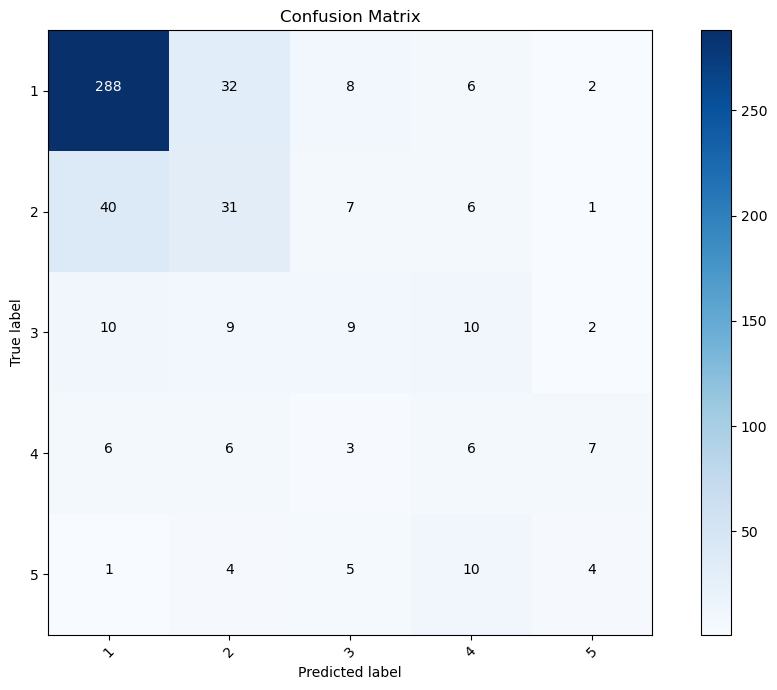

In [14]:
# Confusion_matrix
cx=confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
plt.imshow(cx, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()

classes = ['1', '2', '3', '4', '5']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cx.max() / 2.
for i in range(cx.shape[0]):
    for j in range(cx.shape[1]):
        plt.text(j, i, format(cx[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cx[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [17]:
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.83      0.86      0.85       336
           1       0.38      0.36      0.37        85
           2       0.28      0.23      0.25        40
           3       0.16      0.21      0.18        28
           4       0.25      0.17      0.20        24

    accuracy                           0.66       513
   macro avg       0.38      0.37      0.37       513
weighted avg       0.65      0.66      0.65       513

